# Movie recommendation algorithm
## Notebook for Computational tools project

Project by:

Oscar F. Clausen, s214735

Thomas D. Stycke, s214742

Emil Gejl, s214739

Laurits Bøtkjær, s214731

Also located on GitHub: https://github.com/s214735/CompToolsGrp70

This notebook can be run chronologically - however note that the training/validation split is performed at the top, and should be skipped when doing data analysis.

Import packages and enable the different files where the custom functions are defined

In [1]:
import sys
import os
import re
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import torch
from torch.utils.data import Subset
import numpy as np

# Create path for custom python files
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))


import plots as plots
import lsh as lsh
import baselinemodel as baselinemodel
import knn_func as knn_func

## Load Data

In [ ]:
# Define csv paths
movie_path = os.path.abspath('../data/movies.csv')
rating_path = os.path.abspath('../data/ratings_small.csv')

# Load data
df_movies_original = pd.read_csv(movie_path)
df_ratings_original = pd.read_csv(rating_path)

# Create copies for quick backup
df_movies = df_movies_original.copy()
df_ratings = df_ratings_original.copy()

Optional cell for splitting into train/test data. Only for when validation is to be run

In [3]:
# Unique users and train/val split
unique_users = df_ratings["userId"].unique()
users_train, users_val = train_test_split(unique_users, test_size=0.05, random_state=42)

df_ratings_train = df_ratings[df_ratings["userId"].isin(users_train)].copy()
df_ratings_val   = df_ratings[df_ratings["userId"].isin(users_val)].copy()

# Print for validation
print(f"Total users     : {len(unique_users)}")
print(f"Train users     : {len(users_train)}")
print(f"Validation users: {len(users_val)}")
print(f"Train ratings   : {len(df_ratings_train)}, Validation ratings: {len(df_ratings_val)}")

## Overwrite df_ratings such that we dont need to change the rest of the code
df_ratings = df_ratings_train.copy()

Total users     : 162541
Train users     : 154413
Validation users: 8128
Train ratings   : 23734077, Validation ratings: 1266018


## Dataset preprocessing

In [4]:
# Drop timestamp, we don't need it
df_ratings.drop(columns=["timestamp"], inplace=True)

# Extract year from title
def extract_year(title: str):
    """Extract year from parentheses in title and return (clean_title, year or pd.NA)."""
    match = re.search(r"\((\d{4})\)", title)
    if match:
        year = int(match.group(1))
        clean_title = title[:match.start()].strip()
        return clean_title, year
    else:
        return title.strip(), pd.NA

df_movies[["title", "year"]] = df_movies["title"].apply(
    lambda x: pd.Series(extract_year(x))
)

# Convert datatypes and split genres
df_movies["year"] = df_movies["year"].astype("Int64")
df_movies["genres"] = df_movies["genres"].apply(lambda g: g.split("|"))
df_movies = df_movies.set_index("movieId", drop=False)


# Split ratings into positive and negative
RATING_THRESHOLD = 3.0

df_pos = df_ratings[df_ratings["rating"] >= RATING_THRESHOLD]
df_neg = df_ratings[df_ratings["rating"] < RATING_THRESHOLD]

# Users who liked each movie
movie_users_pos = (
    df_pos.groupby("movieId")["userId"]
    .apply(lambda s: set(map(int, s.to_numpy())))
    .reindex(df_movies.index, fill_value=set())
)

# Users who disliked each movie
movie_users_neg = (
    df_neg.groupby("movieId")["userId"]
    .apply(lambda s: set(map(int, s.to_numpy())))
    .reindex(df_movies.index, fill_value=set())
)

# Genres per movie as a clean set
movie_genres = df_movies["genres"].apply(
    lambda gs: set(g.strip() for g in gs)
)

## Data analysis

The following code contains plots that explore that distribution of the data and preliminary analyses

In [14]:
# Average rating in general
global_avg_rating = df_ratings["rating"].mean()
print(f"Global average rating: {global_avg_rating:.4f}")

# Number of users
num_users = df_ratings["userId"].nunique()
print(f"Number of unique users: {num_users}")

# Number of movies
num_movies = df_movies["movieId"].nunique()
print(f"Number of unique movies: {num_movies}")

# Number of ratings
num_ratings = len(df_ratings)
print(f"Total number of ratings: {num_ratings}")

Global average rating: 3.5339
Number of unique users: 162541
Number of unique movies: 62423
Total number of ratings: 25000095


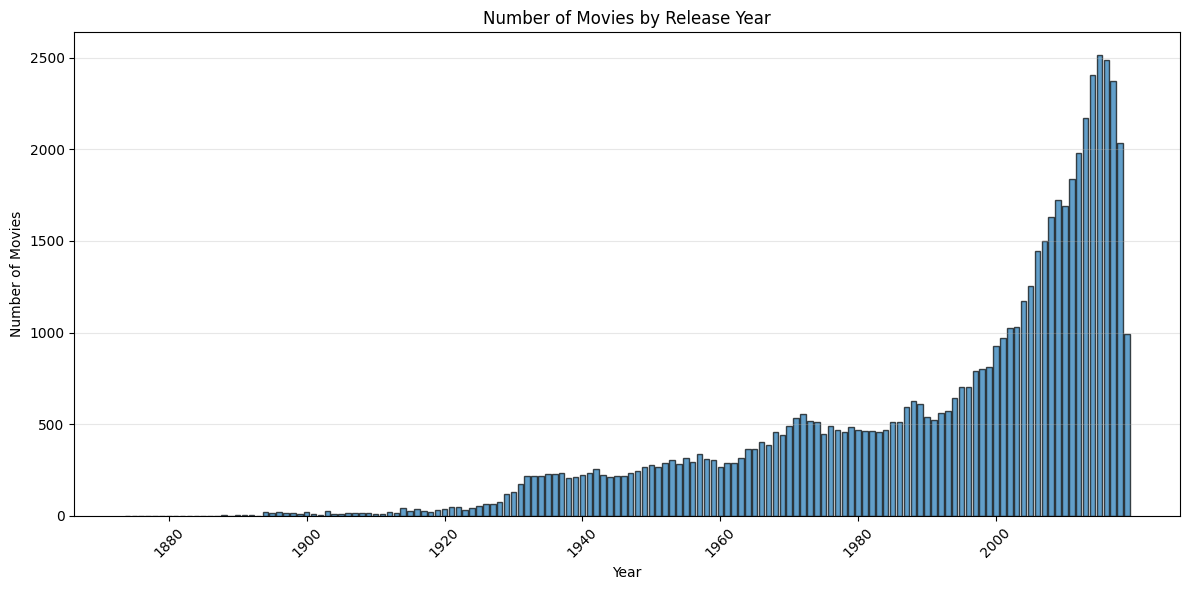

In [5]:
plots.movies_per_year(df_movies)

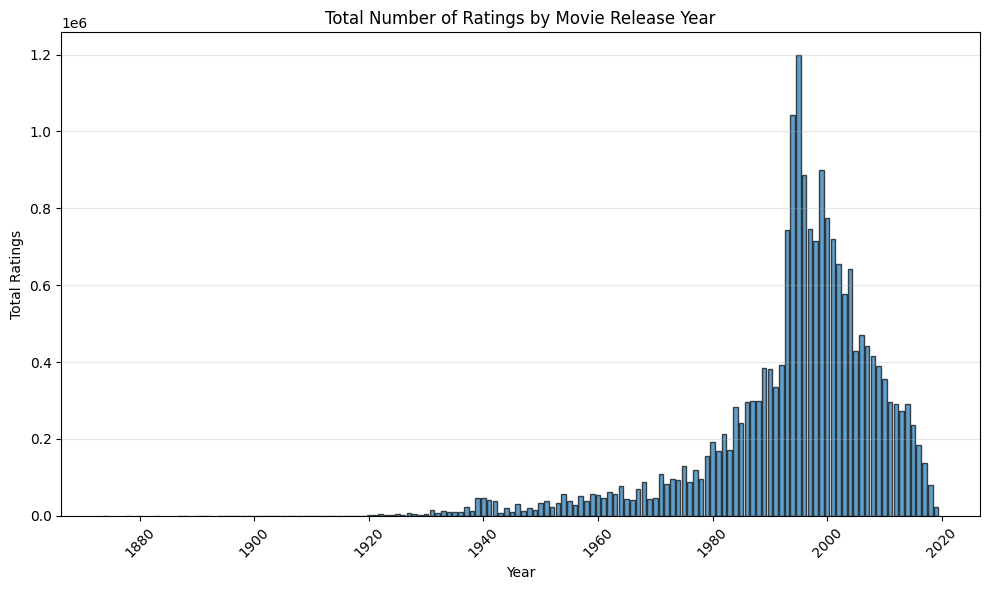

In [6]:
plots.ratings_per_year(df_movies, df_ratings)

Top 10 movies by rating count:
    movieId  rating_count
0      356         65216
1      318         65167
2      296         63651
3      593         59338
4     2571         58205
5      260         54986
6      480         51220
7      527         48382
8      110         47352
9     2959         47094


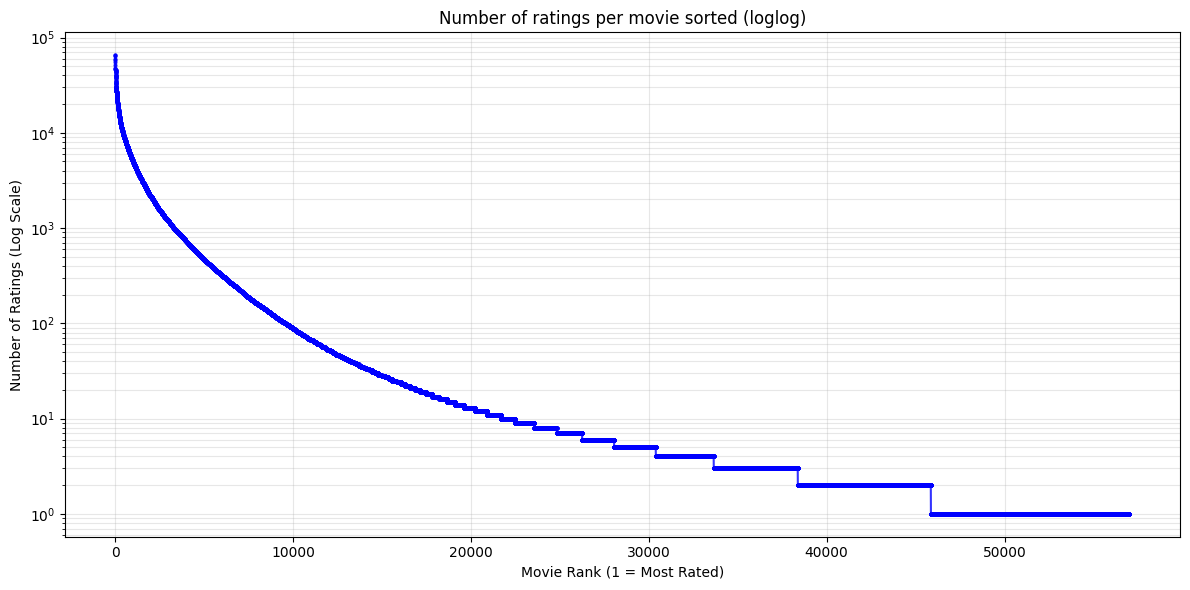

In [7]:
plots.ratings_per_movie(df_ratings)

Cluster sizes:
 0    18495
1    20217
2     8635
3     5596
4     8199
5    15010
6     8127
7     5951
8    23500
9    16302


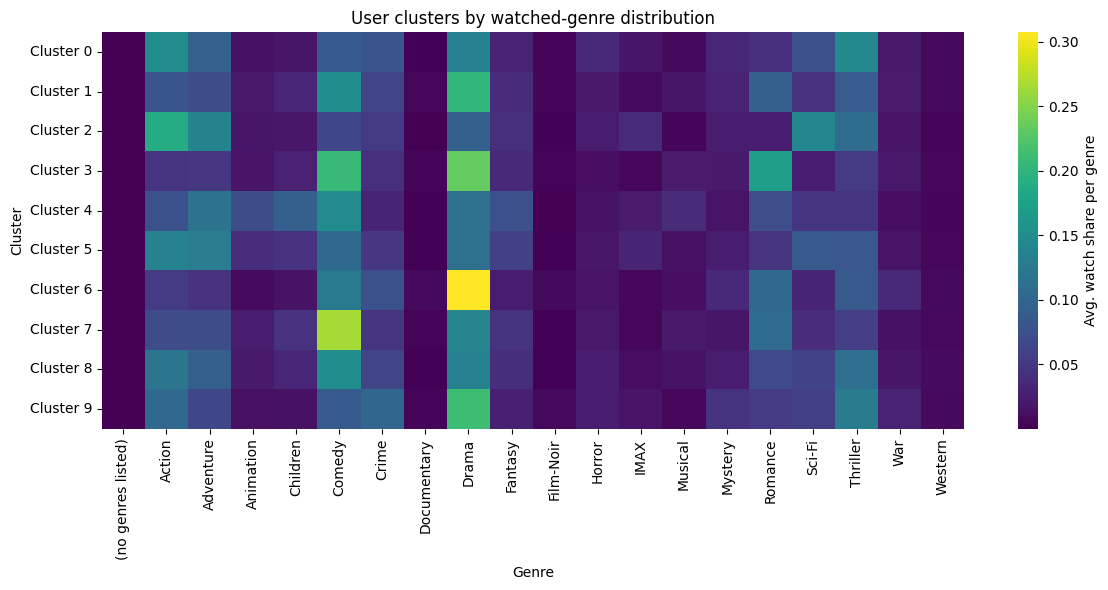

In [8]:
# Create user/genre cluster plot
plots.users_per_genre(df_ratings, df_movies, K=10, random_state=42)

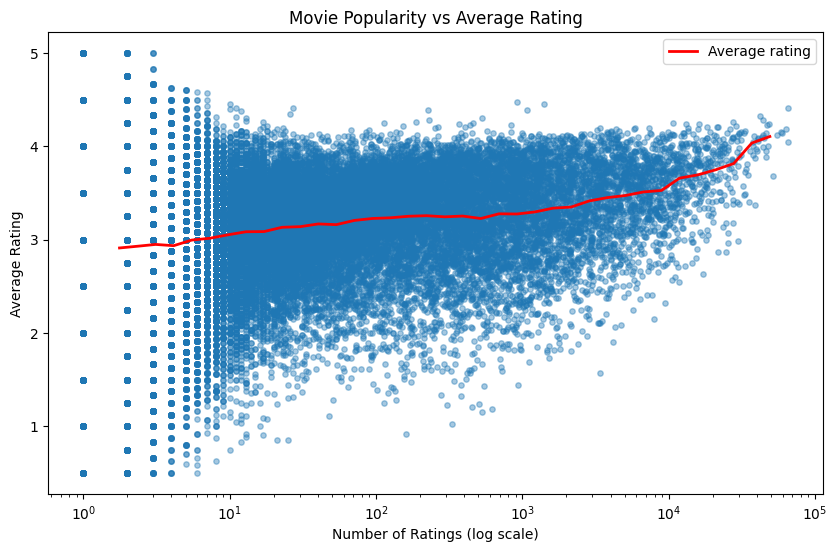

In [9]:
# Plot popularity vs rating
plots.popularity_rating(df_ratings, df_movies)

## LSH-model

Create LSH index

In [10]:
movie_tokens_lsh = lsh.create_movie_tokens_lsh(df_movies, movie_genres, movie_users_pos, movie_users_neg)

num_perm = 128

minhashes = lsh.minhash_signatures(movie_tokens_lsh, num_perm=num_perm)

lsh_index = lsh.minhash_lsh(minhashes, lsh_threshold=0.3, num_perm=num_perm)

Recommend movies. A small 'movie finder' functionality is provided in case specific movies are wanted

In [23]:
lsh.find_movie_by_title("mononoke", df_movies=df_movies)

                                     title  \
movieId                                      
3000     Princess Mononoke (Mononoke-hime)   

                                                 genres  
movieId                                                  
3000     [Action, Adventure, Animation, Drama, Fantasy]  


In [22]:
df_movies[df_movies['movieId'] == 3000]

,movieId,title,genres,year
movieId,,,,
3000,3000,Princess Mononoke (Mononoke-hime),"[Action, Adventure, Animation, Drama, Fantasy]",1997


In [ ]:
# Example: virtual user who likes several movies
seed_movies = [3000]
print("\nSimilar for profile:")
lsh.similar_movies_for_profile(
    seed_movies,
    lsh_index=lsh_index,
    movies_df=df_movies,
    movie_genres=movie_genres,
    movie_users_pos=movie_users_pos,
    movie_users_neg=movie_users_neg,
    top_k=20,
    use_genre=True,
    use_user_pos=True,
    use_user_neg=True,
)


Similar for profile:


,movieId,title,year,J_genre,J_rating,S_user,similarity
20,7099,Nausicaä of the Valley of the Wind (Kaze no ta...,1984.0,0.666667,0.286274,0.286274,0.438431
5,5971,My Neighbor Totoro (Tonari no Totoro),1988.0,0.500000,0.338972,0.338972,0.403383
19,6350,Laputa: Castle in the Sky (Tenkû no shiro Rapy...,1986.0,0.571429,0.282111,0.282111,0.397838
6,1274,Akira,1988.0,0.500000,0.234364,0.234364,0.340619
38,1275,Highlander,1986.0,0.600000,0.098348,0.098348,0.299009
41,1287,Ben-Hur,1959.0,0.600000,0.068540,0.068540,0.281124
32,29,"City of Lost Children, The (Cité des enfants p...",1995.0,0.428571,0.119049,0.119049,0.242858
57,2291,Edward Scissorhands,1990.0,0.333333,0.150642,0.150642,0.223718
1,551,"Nightmare Before Christmas, The",1993.0,0.285714,0.151197,0.151197,0.205004
65,3471,Close Encounters of the Third Kind,1977.0,0.333333,0.116118,0.116118,0.203004


## LSH model validation
Use the train/test split we defined in the top of the notebook!

In [24]:
# Perform similar preprocessing for validation set

# Drop timestamp
df_ratings_val.drop(columns=["timestamp"], inplace=True)
# Perform threshold
df_pos_val = df_ratings_val[df_ratings_val["rating"] >= RATING_THRESHOLD]
user_liked_movies = (
    df_pos_val.groupby("userId")["movieId"]
    .apply(lambda s: sorted(set(s.astype(int))))
)

# Validate the amount in train/test set
n_users_train = df_ratings_train["userId"].nunique()
n_users_val = df_ratings_val["userId"].nunique()
print(n_users_val)
print(n_users_train)

32509
130032


In [ ]:
# Sample validation - this is not what the final results are based on
lsh.validate(df_ratings_val, 
            lsh_index=lsh_index,
            movies_df=df_movies,
            movie_genres=movie_genres,
            movie_users_pos=movie_users_pos,
            movie_users_neg=movie_users_neg,
            RNG_SEED = 42,
            TOP_K_EVAL = 30,
            MASK_USER_MOVIES = 10,
            MIN_RATING_SCORE = 4.0,
            MIN_AMOUNT_MOVIE_OVER_THRESHOLD = 20,
            MAX_USERS_TO_EVAL = 100)

Eligible users (>= 20 positive movies): 24911


100%|██████████| 100/100 [02:28<00:00,  1.48s/it]

Users requested              : 100
Users evaluated              : 100
Average hits per user (0–10) : 1.180
Average per-user hit rate    : 0.118


## Baseline model

Run the baseline model

In [7]:
acc = baselinemodel.baseline_model(ratings_df=df_ratings,
                                      like_threshold=4, 
                                      min_user_likes=20, 
                                      top_k=30, 
                                      users_to_eval=len(users_val), 
                                      holdout_per_user=10,
                                      rng_seed=69)

print("Baseline model hit rate:", acc)

Evaluating users: 100%|██████████| 8128/8128 [03:57<00:00, 34.23it/s]

Baseline model hit rate: 0.19649360236220473


For fun - check what movies have the most positive ratings

In [ ]:
pos_counts = (
    df_ratings.loc[df_ratings["rating"] >= 4, "movieId"]
    .value_counts()
    .index
    .tolist()
)

df_movies[df_movies['movieId'].isin(pos_counts[:30])]

## Deep learning approach using KNN on latents

#### Train model and make predictions for single user
The following code trains the model, makes recommendations and creates a file containing latent representation for users.

This code was run on the hpc in an interactive node. A GPU is required to run it properly.

In [ ]:
# Create the dataset
ds = knn_func.UserRatingDataset(rating_path, movie_path, min_movie_count=10)  # prune very rare movies

# For reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# 80/20 train/val split on users
num_users = len(ds)
indices = np.arange(num_users)
np.random.shuffle(indices)
train_size = int(0.95 * num_users)
train_indices = indices[:train_size]
val_indices = indices[train_size:]
train_ds = Subset(ds, train_indices)
val_ds = Subset(ds, val_indices)

model = knn_func.train_user_ae(train_ds, val_dataset=val_ds, latent_dim=124, epochs=50, batch_size=256, lr=1e-4, save_path="user_ae.pt")

# encode users (using full dataset)
latents = knn_func.build_user_latents(model, ds)
np.save("user_latents.npy", latents)
print("Saved user latents shape:", latents.shape)

# recommend for a user (pick one existing user)
example_user_id = int(ds.user_ids[0])  # first user in dataset
recommendations = knn_func.recommend_by_similar_users(example_user_id, latents, ds,
                                            movies_csv=movie_path,
                                            ratings_csv=rating_path,
                                            top_k_users=30, top_n_items=10)
liked_movies = knn_func.get_user_liked_movies(example_user_id, ds, movies_csv=movie_path, min_rating=5.0)
print(f"\nMovies that user {example_user_id} liked:")
print(liked_movies.to_string(index=False))
print("Top recommendations for user", example_user_id)
print(recommendations.to_string(index=False))

#### Plot of latent space

In [ ]:
knn_func.plot_latent_space(latent_path = "user_latents.npy")

#### Metric computation for latent KNN
In this section we compute the metric for the model

In [ ]:
ratings_csv = "movie_ratings_small.csv"
movies_csv = "movies.csv"
model_path = "user_ae.pt"
latents_path = "user_latents.npy"
knn_func.compute_metric_latent_knn(ratings_csv=ratings_csv, movies_csv=movies_csv, model_path=model_path, latents_path=latents_path)